## Assignments

To close out this checkpoint, you'll do two assignments. Both require you to create Jupyter notebooks. Please submit links to your notebooks below

### 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.


In [30]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
fbeta_score)
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest

sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

In [4]:
df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
# Building regression model
y = df['temperature']
X = df[['humidity', 'windspeed', 'windbearing', 'pressure']]

lrm = linear_model.LinearRegression()
lrm.fit(X, y)


print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528538


In [6]:
# mean of errors should be 0
predictions = lrm.predict(X)
errors = y - predictions

print(f'The mean of the errors is {np.mean(errors)}')
# Used a model that has a constant, so the mean of errors will be 0.
# This is effectively 0. 

The mean of the errors is -4.714704061941714e-16


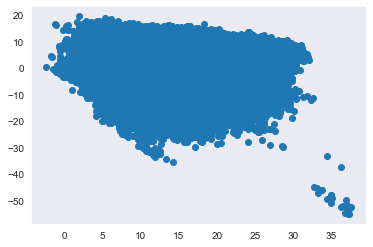

In [7]:
# Plotting Error Distribution to find Homo or Heteroscedasticity
plt.scatter(predictions, errors);

This is only the second plot I've seen of the distribution of errors, but it seems heteroscedastic. Let's run the tests:

In [8]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print(f"Bartlett test statistic value is {bart_stats[0]:3g} and p value is {bart_stats[1]:.3g}")
print(f"Levene test statistic value is {lev_stats[0]:3g} and p value is {lev_stats[1]:.3g}")
# This is confirmed as heteroscedastic

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


Ways to fix the heteroscedasticity would be to include more features that explain the target variable better or perform a box cox on the target

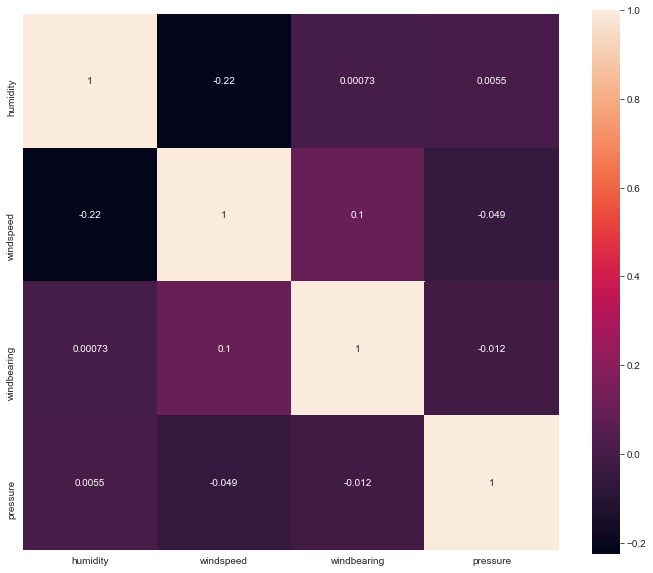

In [9]:
# Assessing multicolinearity of the features
X_corr = X.corr()

plt.figure(figsize=(12,10))
sns.heatmap(X_corr, square=True, annot=True)
# All features have a low multicolinearity

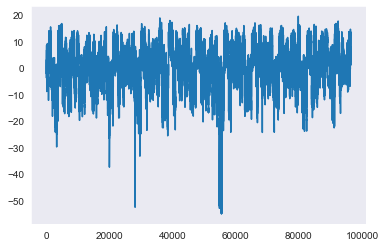

In [10]:
# Errors should not be self correlating
plt.plot(errors)
# Variance in the error is not consistent over all values

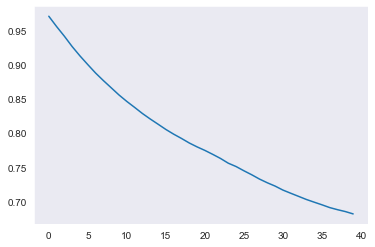

In [11]:
# Running Auto Correlation Function
acf_data = acf(errors)

plt.plot(acf_data[1:])

The Auto Correlation Function was helpful as there seems to be high self correlation of the errors. There is likely a relavent variable we are omitting.

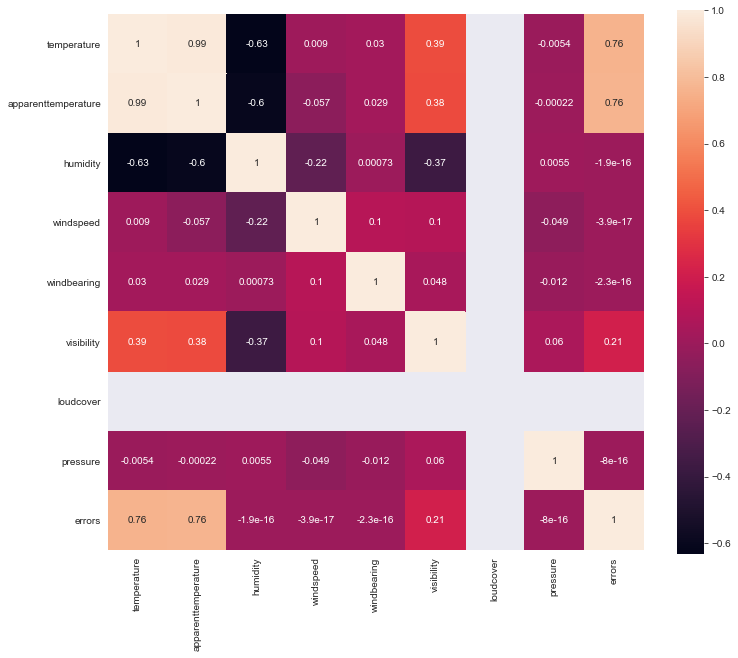

In [12]:
# Features shouldn't be correlated with the errors

df['errors'] = errors
num_cols = df.select_dtypes('float64').columns

df_errors_corr = df[num_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(df_errors_corr, square=True, annot=True);

As we can see here, we should either include the temperature variable or the apparenttemperature variable in our model as it is highly correlated to our errors

### 2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database. 
* Reimplement the model you built in the previous checkpoint. 
* Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.

In [13]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine, index_col='id')

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [14]:
# One hot encoding specific variables
df = pd.concat([df, pd.get_dummies(df['mszoning'], prefix='mszoning', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['exterqual'], prefix='exterqual', drop_first=True)], axis=1)

dummy_col_names = list(pd.get_dummies(df['mszoning'], prefix='mszoning', drop_first=True).columns)
dummy_col_names = dummy_col_names + list(pd.get_dummies(df['exterqual'], prefix='exterqual', drop_first=True).columns)

In [15]:
# Linear Regression
y = df['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_col_names]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 1.79094519e+04  4.55010618e+01  1.33820196e+04  1.12556391e+01
  2.28181908e+01  2.99598546e+04  2.10596292e+04  3.70428384e+04
  1.68775188e+04 -6.57739327e+04 -5.78537365e+04 -7.45250121e+04]

Intercept: 
 -17442.572361415223


In [16]:
# mean of errors should be 0
predictions = lrm.predict(X)
errors = y - predictions

print(f'The mean of the errors is {np.mean(errors)}')
# Used a model that has a constant, so the mean of errors will be 0.
# This is effectively 0. 

The mean of the errors is -2.5994106106562157e-11


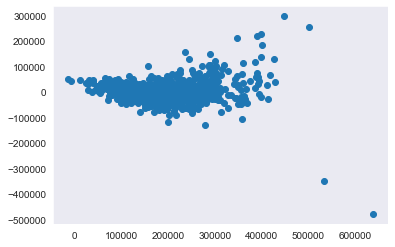

In [17]:
# Plotting Error Distribution to find Homo or Heteroscedasticity
plt.scatter(predictions, errors);

In [18]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print(f"Bartlett test statistic value is {bart_stats[0]:3g} and p value is {bart_stats[1]:.3g}")
print(f"Levene test statistic value is {lev_stats[0]:3g} and p value is {lev_stats[1]:.3g}")
# This is confirmed as heteroscedastic

Bartlett test statistic value is 592.055 and p value is 8.95e-131
Levene test statistic value is 520.058 and p value is 4.54e-106


Ways to fix the heteroscedasticity would be to include more features that explain the target variable better or perform a box cox on the target

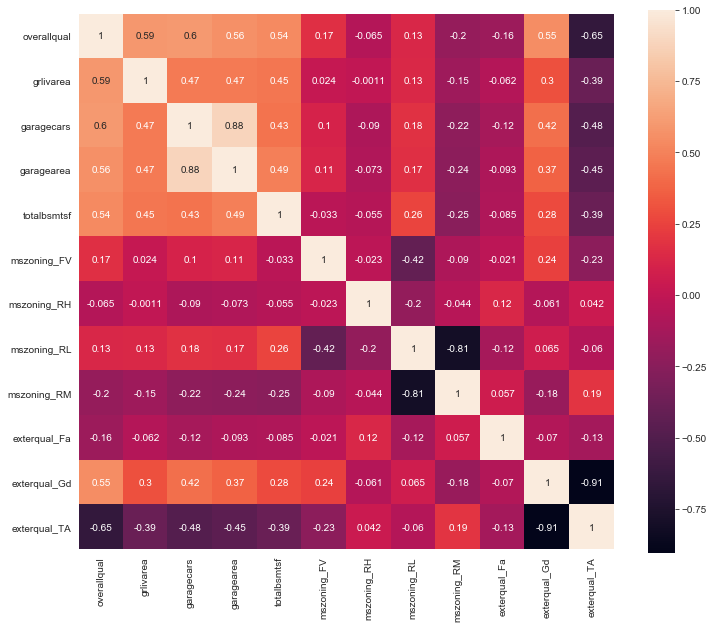

In [19]:
# Assessing multicolinearity of the features
X_corr = X.corr()

plt.figure(figsize=(12,10))
sns.heatmap(X_corr, square=True, annot=True)

garagecars and garagearea are highly correlated (which makes sense since you would need a larger garage to fit more cars). One of these variables should likely be dropped.

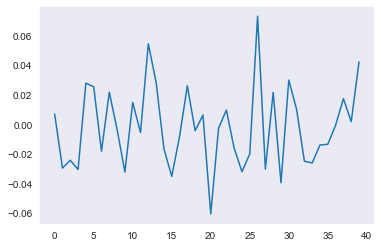

In [20]:
# Running Auto Correlation Function
acf_data = acf(errors)

plt.plot(acf_data[1:])
# Errors do not seem to be correlated with eachother

In [27]:
# Features shouldn't be correlated with the errors

df['errors'] = errors
num_cols = df.select_dtypes(['float64', 'int64']).columns

np.abs(df[num_cols].iloc[:,1:].corr().loc[:,'errors'].sort_values(ascending=False))[:10]

errors          1.000000
saleprice       0.459554
bsmtfullbath    0.186871
bsmtfinsf1      0.180370
lotarea         0.135332
wooddecksf      0.132715
overallcond     0.122690
fireplaces      0.107378
yearremodadd    0.100268
masvnrarea      0.092422
Name: errors, dtype: float64

Variables are not highly correlated to the errors

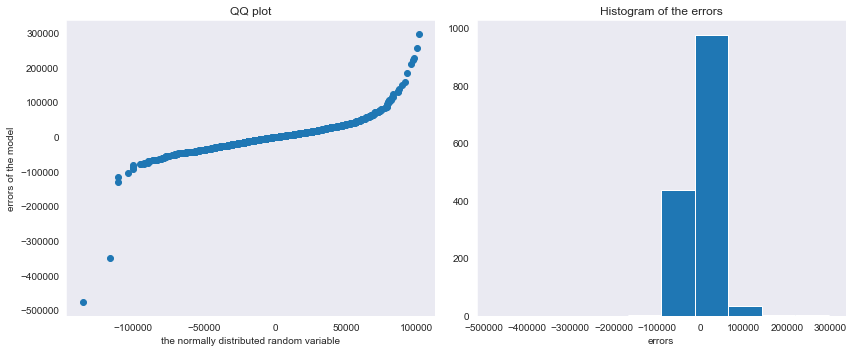

In [28]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [31]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 66518.34615276505 and p value is 0.0
Normality test statistics is 546.2365482395267 and p value is 2.4335520682991236e-119


The errors are not normal